In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dolfin
import logging
logging.getLogger('FFC').setLevel(logging.WARN)
import matplotlib
matplotlib.rc('text', usetex=False)

In [85]:
true = np.loadtxt('true_linear_elliptic.txt')
true_x = true[:,:2]
seed = 124
np.random.seed(seed)

r = np.random.normal(0, 0.1, len(true))
print r
true_u = true[:,2] + r

[ 0.02884791 -0.04629541 -0.13380044  0.23170157 -0.14673759 -0.07485477
 -0.10175214  0.16350668  0.09225456 -0.07198813 -0.09648834  0.02535828
  0.03080074 -0.0071606  -0.11354805 -0.01022454  0.08081862  0.02319924
 -0.14003585  0.07159078 -0.21245676  0.12414134  0.0236312  -0.10888918
  0.07177592  0.00434045 -0.02952642 -0.01971579  0.08078603 -0.10767565
  0.04913325 -0.04511359  0.01965904 -0.21584157  0.05226973  0.01942622]


In [32]:
coefs = [
    (0,0),
    (1,0),
    (0,1),
    (1,1),
    (2,0),
    (0,2)
]

In [33]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [80]:
c = 'exp(t1 + t2*cos(2*pi*x[0])/4. + t3*cos(2*pi*x[1])/9. + t4*cos(2*pi*(x[0]+x[1]))/16. + t5*cos(4*pi*x[0])/25. + t6*cos(4*pi*x[1])/36.)'
c_expr = dolfin.Expression(c, t1=1,t2=1,t3=1,t4=1,t5=1,t6=1)

mesh_size = 10
mesh = dolfin.UnitSquareMesh(mesh_size, mesh_size)
fn_space = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

v = dolfin.TestFunction(fn_space)
u = dolfin.TrialFunction(fn_space)

a = -dolfin.inner(dolfin.nabla_grad(v), c_expr*dolfin.nabla_grad(u))
f = dolfin.inner(v, dolfin.Constant(0))

u_sol = dolfin.Function(fn_space)

def x2_on_bottom_bdy(x, on_bdy):
    return on_bdy and dolfin.near(x[1], 0.)

def x2_on_top_bdy(x, on_bdy):
    return on_bdy and dolfin.near(x[1], 1.)

bcs = [
    dolfin.DirichletBC(fn_space, dolfin.Expression('x[0]'), x2_on_bottom_bdy),
    dolfin.DirichletBC(fn_space, dolfin.Expression('1-x[0]'), x2_on_top_bdy)
]

a_form = a*dolfin.dx
f_form = f*dolfin.dx
# neumann conditions automatically satisfied since they are homogeneous
dolfin.solve(a_form == f_form, u_sol, bcs)

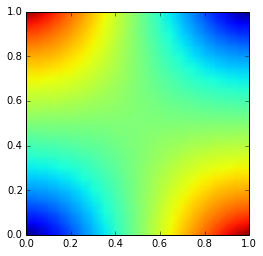

In [71]:
plot(u_sol)

In [72]:
init_theta = np.ones(6)

In [73]:
from scipy import stats
def propose(current):
    return np.random.normal(current, proposal_sigma)
def proposal_proba(proposal, current):
    return stats.multivariate_normal.logpdf(proposal, current, proposal_sigma)
def propose_gibbs(current):
    coord = np.random.choice(len(current))
    ret = current.copy()
    ret[coord] += np.random.normal(0, proposal_sigma)
    return ret
def proposal_proba_gibbs(proposal, current):
    changed = (proposal != current)
    move_proba = stats.multivariate_normal.logpdf(proposal[changed], current[changed], proposal_sigma)
    return move_proba * changed.sum() *1./len(proposal)
def log_likelihood(theta, debug=False):
    c_expr.t1 = theta[0]
    c_expr.t2 = theta[1]
    c_expr.t3 = theta[2]
    c_expr.t4 = theta[3]
    c_expr.t5 = theta[4]
    c_expr.t6 = theta[5]
    
    solution = dolfin.Function(fn_space)
    dolfin.solve(a_form == f_form, solution, bcs)
    mu = np.vectorize(solution)(true_x[:,0], true_x[:,1])
    #cov_with_error = np.eye(mu.shape[0]) * likelihood_sigma**2
    ret = stats.multivariate_normal.logpdf(true_u, mu.ravel(), likelihood_sigma, False)
    return ret
    err = (true_u - mu).reshape((mu.shape[0], 1))
    
    cov_inv = np.eye(mu.shape[0]) * 1. / likelihood_sigma
    inner = -0.5*err.T.dot(cov_inv).dot(err)
    outer = -0.5*np.log(np.linalg.det(2*np.pi*cov_with_error))
    return (inner + outer)[0,0]
def log_prior_lognormal(theta):
    if np.any(theta <= 0): return np.log(0)
    p = stats.norm.logpdf(np.log(theta), np.ones_like(theta), 1.) - np.log(theta)
    return np.sum(p)
def log_prior_normal(theta):
    p = stats.norm.logpdf(theta, np.zeros_like(theta), 1.0)
    return np.sum(p)
def log_prior_uniform(theta):
    theta_min = -20.
    theta_max = 20.
    if any((theta < theta_min) | (theta > theta_max)):
        return np.log(0)
    return len(theta)*np.log(1./(theta_max-theta_min))

In [74]:
log_prior = log_prior_normal
#log_prior = lambda x: 0
#propose = propose_gibbs
#proposal_proba = proposal_proba_gibbs

In [86]:
## #cur_theta = thetas[i,:]
cur_theta = init_theta
# now the MCMC
iterations = 5000
thetas = np.empty((iterations, cur_theta.shape[0]))
proposals = np.empty((iterations, cur_theta.shape[0]))
thetas[0,:] = init_theta
proposal_sigma = 0.5
likelihood_sigma = 0.01

last_likelihood = log_likelihood(thetas[0,:])
last_prior = log_prior(thetas[0,:])
acceptances = np.empty(iterations, dtype=np.bool)
acceptances[0] = True
alphas = np.empty(iterations)

cur_theta = init_theta
update_frequency = int(iterations / 100)
for i in xrange(iterations):
    if i % int(iterations / 100) == 0:
        
        print i, acceptances[i-iterations/100:i].sum() * 1./(iterations * 1./100)
    next_theta = propose(cur_theta)
    proposals[i,:] = next_theta
    
    new_likelihood = log_likelihood(next_theta)
    new_prior = log_prior(next_theta)
    
    alpha = np.exp(new_likelihood + new_prior)*np.exp(-(last_likelihood + last_prior))
    if np.isnan(alpha): 
        raise Exception()
    else:
        accept = np.random.uniform() < alpha
    alphas[i] = alpha
    acceptances[i] = accept
    if accept == True:
        #print 'Accepted'
        cur_theta = next_theta
        last_likelihood = new_likelihood
        last_prior = new_prior
    
    thetas[i,:] = cur_theta


0 0.0
50 0.46
100 0.56
150 0.5
200 0.52
250 0.56
300 0.56
350 0.54
400 0.56
450 0.56
500 0.62
550 0.62
600 0.56
650 0.6
700 0.5
750 0.54
800 0.58
850 0.6
900 0.56
950 0.64
1000 0.7
1050 0.58
1100 0.56
1150 0.38
1200 0.56
1250 0.52
1300 0.64
1350 0.66
1400 0.56
1450 0.62
1500 0.52
1550 0.52
1600 0.62
1650 0.48
1700 0.56
1750 0.54
1800 0.52
1850 0.5
1900 0.52
1950 0.48
2000 0.68
2050 0.56
2100 0.5
2150 0.66
2200 0.54
2250 0.56
2300 0.56
2350 0.54
2400 0.48
2450 0.5
2500 0.52
2550 0.62
2600 0.66
2650 0.66
2700 0.58
2750 0.46
2800 0.38
2850 0.5
2900 0.6
2950 0.54
3000 0.64
3050 0.56
3100 0.64
3150 0.54
3200 0.58
3250 0.56
3300 0.66
3350 0.52
3400 0.6
3450 0.4
3500 0.56
3550 0.56
3600 0.64
3650 0.6
3700 0.54
3750 0.5
3800 0.48
3850 0.68
3900 0.44
3950 0.62
4000 0.6
4050 0.56
4100 0.4
4150 0.42
4200 0.48
4250 0.56
4300 0.54
4350 0.58
4400 0.64
4450 0.62
4500 0.62
4550 0.62
4600 0.52
4650 0.58
4700 0.7
4750 0.6
4800 0.6
4850 0.64
4900 0.58
4950 0.66


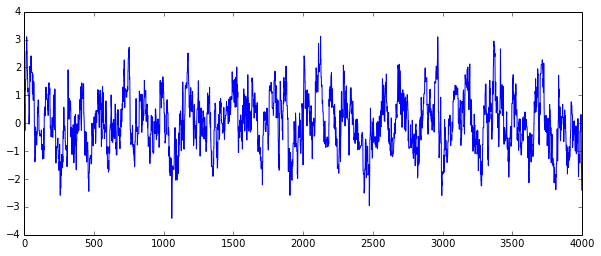

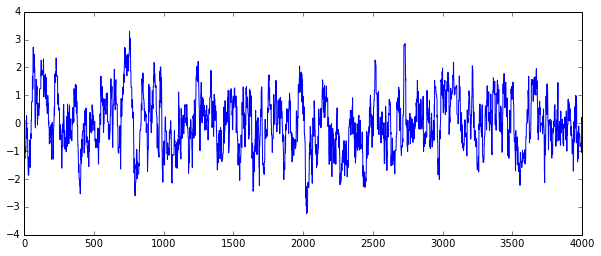

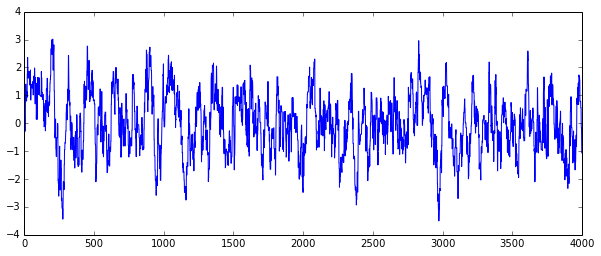

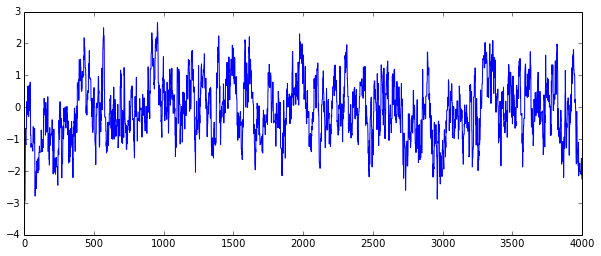

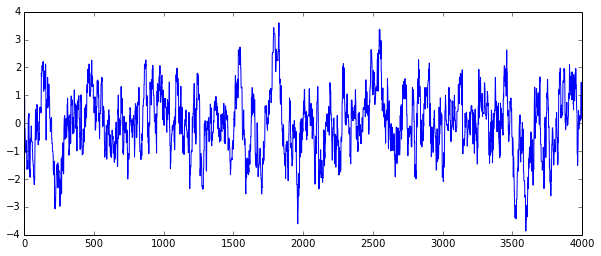

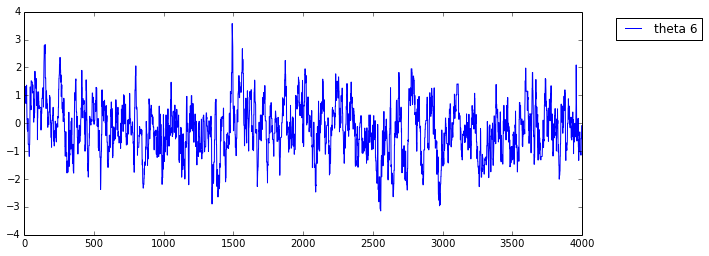

In [87]:
plt.figure(figsize=(8,5))
#print acceptances.sum() * 1./iterations
thin= 1
burn = 1000
thinned_burned = thetas[burn:-1:thin, :]
for i in xrange(6):
    plt.figure(figsize=(10,4))
    plt.plot(thinned_burned[:,i], label='theta {}'.format(i+1))
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

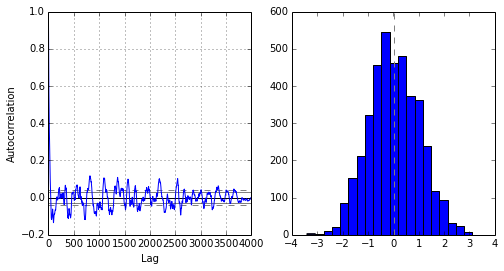

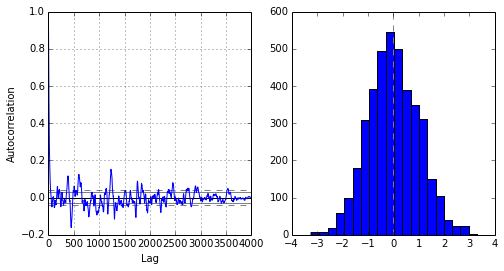

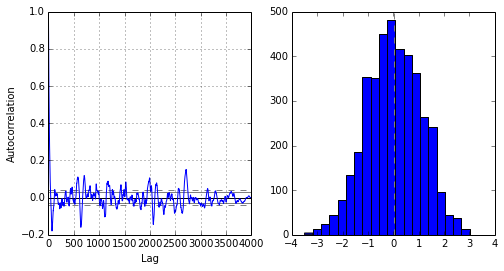

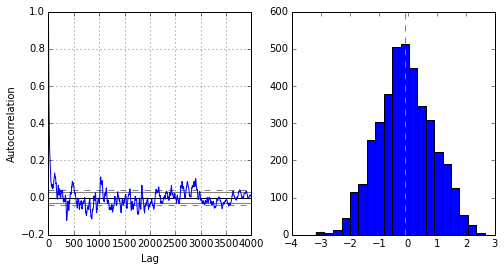

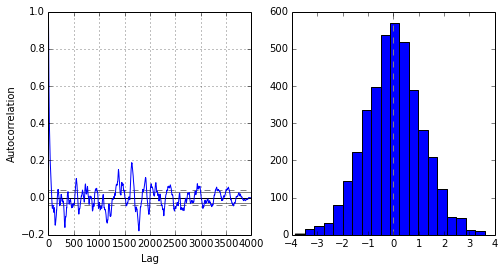

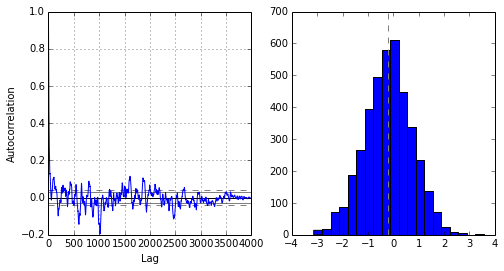

In [88]:
from pandas.tools.plotting import autocorrelation_plot
for i in xrange(thinned_burned.shape[1]):
    t = thinned_burned[:,i]
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    autocorrelation_plot(t, ax=plt.gca())
    plt.subplot(122)
    plt.hist(t, bins=20)
    plt.axvline(t.mean(), linestyle='--', c='gray')

In [89]:
import math
def integers_between(min, max):
    min_int = int(math.floor(min))
    max_int = int(math.ceil(max))
    print min_int, max_int
    return range(min_int, max_int+1)

-4 4
-4 4
-4 4
-4 4
-4 3
-4 4


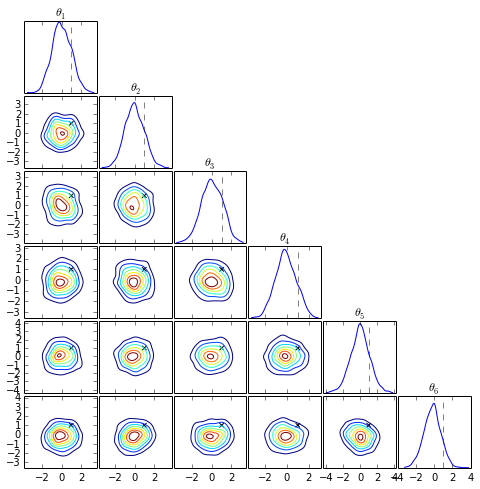

In [90]:
from matplotlib import gridspec
from scipy import stats
plt.figure(figsize=(8,8))
diag = []
n = 6
gs = gridspec.GridSpec(n, n)
gs.update(wspace=0.025, hspace=0.05)

#levels = [5,20,40,60]

levels = None
for i in range(n):
    i_data = thinned_burned[:,i]
    ax = plt.subplot(gs[n*i + i])
    kde = stats.gaussian_kde(i_data)
    eval_points = np.linspace(i_data.min()-0.1, i_data.max()+0.2, 100)
    #plt.axvline(i_data.mean(), linestyle='--', color='gray')
    plt.axvline(1, linestyle='--', color='gray')
    #plt.axvline(-1, linestyle='--', color='gray')
    plt.plot(eval_points, kde(eval_points))
    plt.title('$\\theta_{}$'.format(i+1))
    
    
    ax.get_yaxis().set_ticks([])
    if i < n-1:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.xticks(integers_between(i_data.min(), i_data.max())[::2])
    for j in range(0,i):
        j_data = thinned_burned[:,j]
        subax = plt.subplot(gs[n*i+j], sharex=diag[j])
        #H,xedges,yedges = np.histogram2d(j_data, i_data, bins=20)
        kde = stats.gaussian_kde(np.c_[j_data, i_data].T, bw_method=0.35)
        x,y = np.mgrid[j_data.min()-0.1:j_data.max()+0.1:100j, i_data.min()-0.1:i_data.max()+0.2:100j]
        plt.contour(x, y, kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape))
        #plt.contour(xedges[:-1], yedges[:-1], H, levels=levels)
        if j > 0:
            subax.get_yaxis().set_ticks([])
        if i < n-1:
            plt.setp(subax.get_xticklabels(), visible=False)
        else:
            plt.xticks(integers_between(j_data.min(), j_data.max())[::2])
        #plt.scatter([1,1,-1,-1],[1,-1,1,-1], marker='x', color='black', linewidth=2, zorder=10)
        plt.scatter(1,1,marker='x', color='black')
    diag.append(ax)
    
plt.gcf().patch.set_alpha(0)
#plt.savefig('FEM.pdf', bbox_inches='tight')
#plt.savefig('FEM_{}.pdf'.format(seed), bbox_inches='tight')

In [23]:
i_data.max()

-0.030029997710845191

In [154]:
matplotlib.get_configdir()

'/home/fenics/.config/matplotlib'

In [151]:
import sys
sys.path = ['/Library/TeX/texbin/'] + sys.path

In [150]:
sys.path

['',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-x86_64-linux-gnu',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/PILcompat',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/pymodules/python2.7',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/fenics/.ipython',
 '/Library/TeX/texbin/']

In [136]:
(H > 2).sum()

In [139]:
(H > 10).sum()

In [145]:
(H > 80).sum()

In [185]:
#np.save('fem_n=11.npy', thetas)

In [ ]:
np.exp(-last_likelihood - last_prior)

In [ ]:
np.exp(new_likelihood + new_prior)

In [ ]:
posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [cur_theta])
mu,cov = posterior(true_x)

In [ ]:
np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u)

In [ ]:
np.exp(0.5*np.log(np.linalg.det(cov+likelihood_sigma**2*np.eye(cov.shape[0]))) + np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u))